In [1]:
import sys, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from os.path import isfile
from scipy.stats import ttest_ind, levene
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Prepare Data

In [2]:
# Combine dataset into a single csv file

countries = ['DE', 'FR', 'GB', 'IN', 'US', 'CA']

def get_category(file):
    data = pd.read_json(file)
    result = pd.DataFrame(columns=['category_id', 'category'])
    result['category_id'] = data['items'].apply(lambda item: np.int64(item['id']))
    result['category'] = data['items'].apply(lambda item: item['snippet']['title'])
    return result

def combine_data_all_countries():
    result = pd.DataFrame()
    for country in countries:
        data_file = 'data/' + country + 'videos.csv'
        category_file = 'data/' + country + '_category_id.json'
        # get data from csv file
        data = pd.read_csv(data_file)
        data['country'] = country
        # get data from json file
        category = get_category(category_file)

        full_data = data.merge(category, on='category_id')
        result = pd.concat([result, full_data], ignore_index=True)
    result = result.drop(columns=['category_id'])
    # save combined data
    result.to_csv('data/final_data.csv', index=False, line_terminator='\n')

In [3]:
# Execute if final_data.csv has not been generated

if not isfile('data/final_data.csv'):
    combine_data_all_countries()

In [4]:
# Read the csv file as a Pandas DataFrame

fd = pd.read_csv('data/final_data.csv', lineterminator='\n')
fd['music'] = (fd['category'] == 'Music')

In [5]:
# Helper functions

def get_comments_ratings(data):
    return (~data['comments_disabled']) & (~data['ratings_disabled'])


def compute_interactive(data):
    return (data['likes'] + data['dislikes'] + data['comment_count']) / data['views']

## Question 1
### Predicting the number of comments that a video will have

In [6]:
X_columns = ['views', 'likes', 'dislikes']
y_column = 'comment_count'

In [7]:
def get_data(data, category):
    comments_ratings_enabled = get_comments_ratings(data)
    if (category is not None):
        valid_comment = data[comments_ratings_enabled & (data['category'] == category)]
    else:
        valid_comment = data[comments_ratings_enabled]
    
    X, y = valid_comment[X_columns], valid_comment[y_column]
    return X, y

In [8]:
# predict comment_count using LinearRegression

def predict_comment():
    print("All countries:")
    data = fd.dropna()
    X, y = get_data(data, None)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)

    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)
    print('score_on_train_data=%.5g' % (model.score(X_train, y_train)))
    print('score_on_valid_data=%.5g' % (model.score(X_valid, y_valid)))

    # for each category
    print("\nFor each category:")
    list_of_category = data['category'].unique()
    for category in list_of_category:
        X, y = get_data(data, category)
        # only consider data with > 40 rows
        if (X.shape[0] > 40):
            X_train, X_valid, y_train, y_valid = train_test_split(X, y)

            model = LinearRegression(fit_intercept=True)
            model.fit(X_train, y_train)
            print('category: %s, score_on_train_data=%.5g' \
                  % (category, model.score(X_train, y_train)))
            print('category: %s, score_on_valid_data=%.5g' \
                  % (category, model.score(X_valid, y_valid)))

In [9]:
predict_comment()

All countries:
score_on_train_data=0.81267
score_on_valid_data=0.83761

For each category:
category: Entertainment, score_on_train_data=0.94264
category: Entertainment, score_on_valid_data=0.94149
category: Comedy, score_on_train_data=0.52017
category: Comedy, score_on_valid_data=0.50616
category: Education, score_on_train_data=0.71739
category: Education, score_on_valid_data=0.80956
category: People & Blogs, score_on_train_data=0.73142
category: People & Blogs, score_on_valid_data=0.54368
category: Film & Animation, score_on_train_data=0.70717
category: Film & Animation, score_on_valid_data=0.68711
category: Autos & Vehicles, score_on_train_data=0.58639
category: Autos & Vehicles, score_on_valid_data=0.54197
category: Sports, score_on_train_data=0.84927
category: Sports, score_on_valid_data=0.87965
category: Howto & Style, score_on_train_data=0.3727
category: Howto & Style, score_on_valid_data=0.34667
category: News & Politics, score_on_train_data=0.64019
category: News & Politics, sc

## Question 2
Can we classify YouTube video categories based on the video's statistics?

In [10]:
# This is enough data for deep learning

fd.shape[0]

239023

In [11]:
# Prepare data for training and testing

X = fd[['views', 'comment_count', 'likes', 'dislikes']]
y = fd['category']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
# Create the models

def create_models():
    bayes = make_pipeline(
        StandardScaler(), 
        GaussianNB()
    )

    knn = make_pipeline(
        StandardScaler(), 
        KNeighborsClassifier(n_neighbors=9)
    )


    mlp = make_pipeline(
        StandardScaler(), 
        MLPClassifier(hidden_layer_sizes=(5, 5))
    )

    decision = DecisionTreeClassifier(max_depth=30)

    rand = RandomForestClassifier(
        n_estimators=10, 
        max_depth=20, 
        min_samples_leaf=10
    )

    return [bayes, knn, mlp, decision, rand]

In [13]:
# Train the models

def train_models(models):
    train, test = [], []

    for model in models:
        model.fit(X_train, y_train)
        train.append(model.score(X_train, y_train))
        test.append(model.score(X_test, y_test))
    
    return train, test

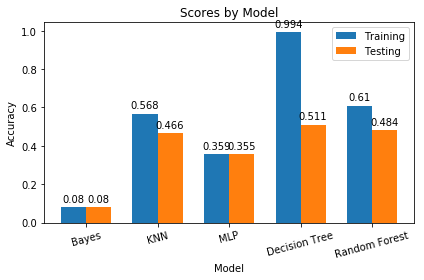

In [14]:
# Plot scores for each model

train, test = train_models(create_models())

labels = ['Bayes', 'KNN', 'MLP', 'Decision Tree', 'Random Forest']
width = 0.35
index = np.arange(5)

train = list(map(lambda x: round(x, 3), train))
test = list(map(lambda x: round(x, 3), test))

ax = plt.subplot(111)
rects1 = ax.bar(index-width/2, train, width=width, align='center')
rects2 = ax.bar(index+width/2, test, width=width, align='center')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Scores by Model')
plt.xticks(index, labels, rotation=15)
plt.legend(['Training', 'Testing'])
plt.tight_layout()
# plt.savefig('model_score')

# Adapted from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

# fig.tight_layout()

plt.show()

In [15]:
# Refine categories to music and non-music

music = fd[fd['music']]
non_music = fd[~fd['music']]

prep = music.append(non_music)
    
X = prep[['views', 'comment_count', 'likes', 'dislikes']]
y = prep['music']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
# Before we start, keep in mind that about 86% of the data
# is non_music, so it is quite easy to obtain a good score

(len(y_test) - np.sum(y_test)) / len(y_test)

0.8557969074235223

In [17]:
# Create, train, and score the model

model = RandomForestClassifier(
    n_estimators=10, 
    max_depth=20, 
    min_samples_leaf=10
)
model.fit(X_train, y_train)

model.score(X_train, y_train), model.score(X_test, y_test)

(0.9239681592261821, 0.905549233549769)

In [18]:
# The model can make these predictions just from a few numbers

res = X_test.copy()
res['y_pred'] = model.predict(X_test)
res['y_test'] = y_test
res.head(10)

,views,comment_count,likes,dislikes,y_pred,y_test
31964,36024,244,2499,100,False,False
22736,13452,0,0,0,False,False
195128,1370348,1754,55496,592,False,False
198755,49167,14,197,29,False,True
108300,25649,201,918,21,False,False
204667,71608,344,3478,36,False,False
7234,2507,41,188,17,False,False
137529,1005259,2775,45800,1933,False,False
185768,144594,447,6215,194,False,True
210188,651071,3196,28575,1777,False,False


## Question 3
Are music videos less interactive compared to non-music videos?

In [19]:
# Remove videos where comments and ratings are disabled
# and find the ratio = (like + dislikes + comments) / views

fd = fd[get_comments_ratings(fd)]

fd['interactive'] = compute_interactive(fd)

In [20]:
# Split into music and non-music

music = fd[fd['music']]
non_music = fd[~fd['music']]

music.shape[0]

33958

Text(0, 0.5, 'count')

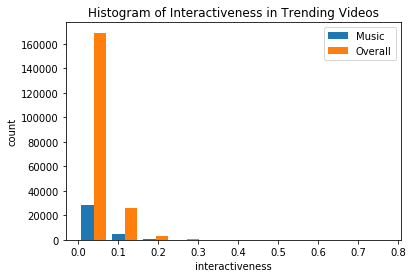

In [21]:
# The regular histogram doesn't tell us a lot

plt.hist([music['interactive'], non_music['interactive']])
plt.legend(['Music', 'Overall'])
plt.xlabel('interactiveness')
plt.title('Histogram of Interactiveness in Trending Videos')
plt.ylabel('count')

Text(0.5, 1.0, 'Transformed Histogram of Interactiveness in Trending Videos')

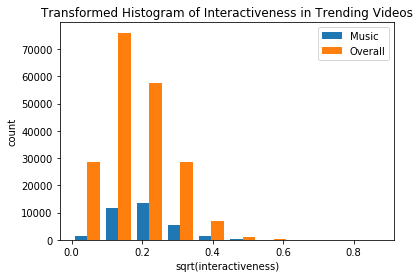

In [22]:
# The sqrt transform works quite well; by CLT, we can assume normality

plt.hist([np.sqrt(music['interactive']), np.sqrt(non_music['interactive'])])
plt.legend(['Music', 'Overall'])
plt.xlabel('sqrt(interactiveness)')
plt.ylabel('count')
plt.title('Transformed Histogram of Interactiveness in Trending Videos')

In [23]:
# However, we cannot assume equal variance

sqrt_music = np.sqrt(music['interactive'])
sqrt_non_music = np.sqrt(non_music['interactive'])

levene(sqrt_music, sqrt_non_music).pvalue

1.8331143598771474e-221

In [24]:
# The p-value is...

ttest_ind(sqrt_music, sqrt_non_music,equal_var=False).pvalue

0.0

## Question 4
### How many views does it take for a video to get to trending?

In [25]:
# First, drop data entries with NaN values to 
# exclude videos with comments or ratings disabled

data = fd.dropna()

In [26]:
# prepare data

average = data.groupby('category').mean()
average['interactive'] = compute_interactive(average)
average = average.sort_values(by=['views'], ascending=False)

(array([      0., 1000000., 2000000., 3000000., 4000000., 5000000.,
        6000000., 7000000., 8000000.]), <a list of 9 Text yticklabel objects>)

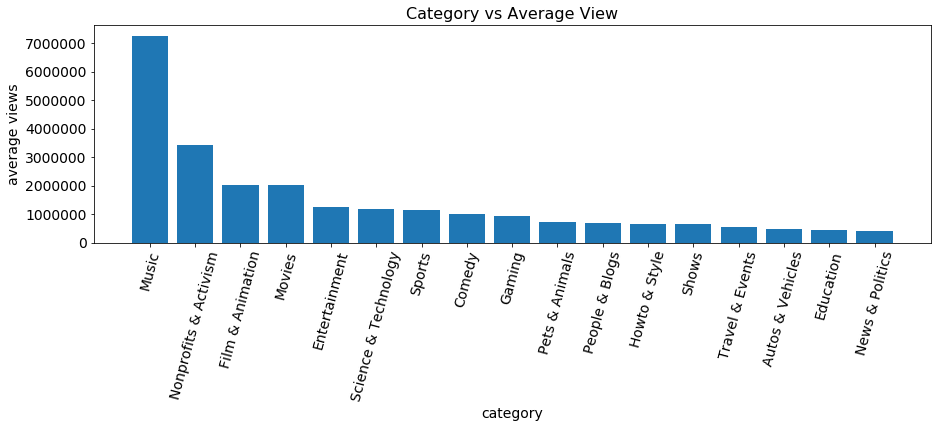

In [34]:
# plot the average Category vs Average View

plt.figure(figsize=(15, 4))
plt.bar(average.index, average['views'])
plt.xticks(rotation=75)
plt.xlabel('category', size = 14)
plt.ylabel('average views', size = 14)
plt.title('Category vs Average View', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16]),
 <a list of 9 Text yticklabel objects>)

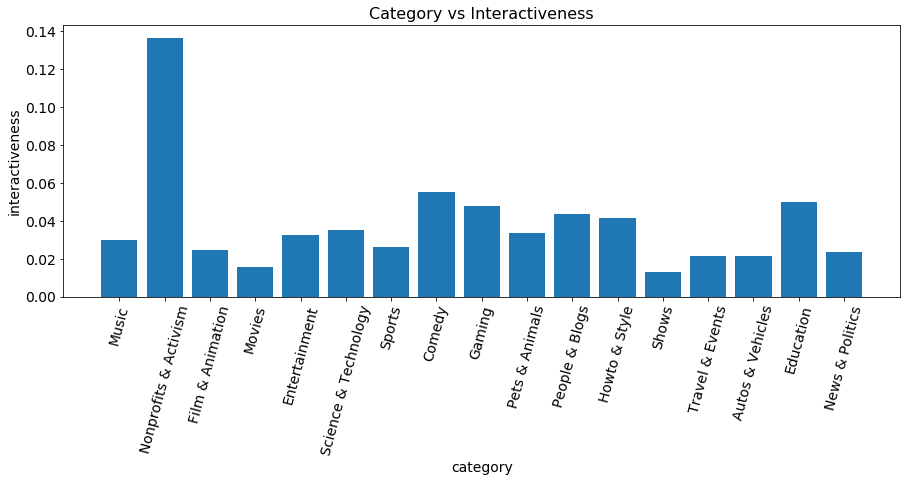

In [28]:
# plot the category vs Interactiveness

plt.figure(figsize=(15, 5))
plt.bar(average.index, average['interactive'])
plt.xticks(rotation=75)
plt.xlabel('category', size = 14)
plt.ylabel('interactiveness', size = 14)
plt.title('Category vs Interactiveness', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)